# Preamble

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline

In [3]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

import numpy as np
import pickle

from multiprocessing import Pool 
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from tqdm import tqdm_notebook as tqdm


import integrals as integ
import diff_eq_multi_2 as diff_eq
import physics as phys

# Load the standard solution.
a = pickle.load(open('../data/std_soln_He.p','rb'))

std_Tm = interp1d(a[0,:], a[1,:])
std_xH = interp1d(a[0,:], a[2,:])

# Constraints on $Q_\mathrm{eff}$

In [4]:
def max_Q_d_eff(m_m, m_C, f, Q):
    
    g_em    = np.sqrt(4*np.pi*phys.alpha)
    mu_pC   = m_C*phys.mp/(m_C + phys.mp)
    f_ratio = 1. + phys.omega_baryon/(f*phys.omega_DM)
    
    max_SI             = 0.26*(m_C/1e9)**(3/8) * np.sqrt(np.sqrt(4*np.pi)/g_em)
    max_CMB            = 1e-3 * np.sqrt(m_C/1e9) * np.sqrt(m_m/1e9) * (1e9/(m_m + m_C))**0.25 * f_ratio**0.25
    max_tight_coupling = 0.08 * np.sqrt(Q) * np.sqrt(m_C/1e8) * (1e9/m_m)**0.25
    
    return np.min((max_SI, max_CMB, max_tight_coupling))

# Function for Solving ODE

In [5]:
 def solve_ODE(params):
        
    _m_m      = params[0]
    _m_C      = params[1]
    _f        = params[2]
    _Q        = params[3]
    _rtol     = params[4]
    _max_step = params[5] 
    
    _Q_d_eff = max_Q_d_eff(_m_m, _m_C, _f, _Q)

    def to_integrate(rs, var):

        neutral_H  = True
        neutral_He = True

        return diff_eq.DM_baryon_ODE(
            rs, var,
            _m_m, _m_C, _Q, _Q_d_eff, neutral_H, neutral_He, _f, True, zero_V_rel=True
        )

    # Number of attempts. 
    N_attempts = 0
    solved     = False

    error_arr = [] 

    while (not solved) and (N_attempts < 3):

        try:

            N_attempts += 1

            soln = solve_ivp(
                to_integrate, [rs_vec[0], rs_vec[-1]], init_cond, 
                method='BDF', t_eval=rs_vec, 
                rtol=_rtol, max_step=_max_step
            )

        except:
            # solve_ivp returned an error. Adjust the tolerance
            # and step size and try again. 

            _rtol /= 1.2
            _max_step /= 1.5

        else:
            # solve_ivp completed successfully. Check the solution though:
            if soln['t'].size == rs_vec.size and not np.isnan(soln['y']).any():

                solved = True

    if not solved:

        soln = False

    return soln 

# Fixed Parameters

In [6]:
rs_start = 4000
rs_vec   = np.flipud(np.arange(10., rs_start, 1))

# Fixed Parameters
f   = 1e-4
m_C = 1e8   

# Loop Points
m_m_arr = 10**np.arange(6.2, 13.2, 0.2)
Q_arr   = 10**np.arange(-6.,  0.2, 0.2) # 31 entries

# Loop

In [ ]:
soln_arr  = np.zeros((m_m_arr.size, Q_arr.size, rs_vec.size, 6))

error_arr = []

for i,m_m in enumerate(tqdm(m_m_arr)):
    
    # Initial conditions are T_CMB - T_b, T_b - T_m, log(T_C), log(V_bm), log(V_cb), xe
    init_cond = [1e-5, 1e-5, np.log(1e-6), np.log(1e-16), np.log(1e-16), 1.] 
#     init_cond = [1e-5, 1e-5, np.log(1e-6), np.log(1e-16), np.log(29e5/phys.c), 1.] 
    
    params = zip(
        m_m*np.ones_like(Q_arr) , m_C*np.ones_like(Q_arr),
        f*np.ones_like(Q_arr)   , Q_arr,
        1e-4*np.ones_like(Q_arr), np.inf*np.ones_like(Q_arr) 
    )
    
    
    # Parallelization.
    
    pool = Pool(Q_arr.size)
    
    soln_raw_arr = list(tqdm(pool.imap(solve_ODE, params)))
    
    for j,soln_raw in enumerate(soln_raw_arr): 
    
        if soln_raw:

            soln = np.transpose(soln_raw['y'])
            
            soln_arr[i,j] = soln

            # Convert to (T_b, T_m, T_C, V_bm, V_mC)
            soln_arr[i,j,:,0] = phys.TCMB(rs_vec) - soln_arr[i,j,:,0]
            soln_arr[i,j,:,1] = soln_arr[i,j,:,0] - soln_arr[i,j,:,1]
            soln_arr[i,j,:,2] = np.exp(soln_arr[i,j,:,2])
            soln_arr[i,j,:,3] = np.exp(soln_arr[i,j,:,3])
            soln_arr[i,j,:,4] = np.exp(soln_arr[i,j,:,4])

        else:
        
            error_arr.append([i,j])
            
    print('Errors: ', error_arr)
        

In [7]:
# pickle.dump((soln_arr, error_arr), open('/home/hongwanl/millicharged_DM_with_bath/notebooks/data.p','wb'))

soln_arr, error_arr = pickle.load(open('/home/hongwanl/millicharged_DM_with_bath/notebooks/data.p','rb'))

    

# Handling Problematic Points

In [13]:
print('Number of problematic points: ', len(error_arr))

m_m_err_arr = np.array([m_m_arr[pt[0]] for pt in error_arr])
Q_err_arr   = np.array([Q_arr[pt[1]] for pt in error_arr])

solved_arr  = [False for _ in error_arr]

# Initial conditions are T_CMB - T_b, T_b - T_m, log(T_C), log(V_bm), log(V_cb), xe
init_cond = [2e-2, 2e-2, np.log(3e-4), np.log(1e-16), np.log(1e-16), 1.] 
#     init_cond = [1e-5, 1e-5, np.log(1e-6), np.log(1e-16), np.log(29e5/phys.c), 1.] 

# Strategies: adjust step-size, initial conditions

params_full = np.transpose([
    np.arange(len(error_arr)),
    [err_ind[0] for err_ind in error_arr],
    [err_ind[1] for err_ind in error_arr],
    m_m_err_arr                   , m_C*np.ones_like(m_m_err_arr),
    f*np.ones_like(m_m_err_arr)   , Q_err_arr,
    7e-10*np.ones_like(m_m_err_arr), np.inf*np.ones_like(m_m_err_arr) 
])

param_chunks = np.array_split(params_full, m_m_err_arr.size//Q_arr.size + 1)

for params in tqdm(param_chunks):
    
    # Parallelization.

    pool = Pool(Q_arr.size)

    soln_raw_arr = list(tqdm(pool.imap(solve_ODE, params[:,3:])))

    for err_ind,i,j,soln_raw in zip(
        params[:,0].astype(int), 
        params[:,1].astype(int), params[:,2].astype(int), soln_raw_arr
    ): 

        if soln_raw:

            soln = np.transpose(soln_raw['y'])

            soln_arr[i,j] = soln

            # Convert to (T_b, T_m, T_C, V_bm, V_mC)
            soln_arr[i,j,:,0] = phys.TCMB(rs_vec) - soln_arr[i,j,:,0]
            soln_arr[i,j,:,1] = soln_arr[i,j,:,0] - soln_arr[i,j,:,1]
            soln_arr[i,j,:,2] = np.exp(soln_arr[i,j,:,2])
            soln_arr[i,j,:,3] = np.exp(soln_arr[i,j,:,3])
            soln_arr[i,j,:,4] = np.exp(soln_arr[i,j,:,4])

            print('Solved: [', i, ', ', j, ']')
            solved_arr[err_ind] = True

error_arr = [ind for solved,ind in zip(solved_arr,error_arr) if not solved]

print(error_arr)

pickle.dump((soln_arr, error_arr), open('/home/hongwanl/millicharged_DM_with_bath/notebooks/data.p','wb'))



Number of problematic points:  3


../diff_eq_multi_2.py:158: RuntimeWarning: invalid value encountered in sqrt
  u_m   = np.sqrt(T_m / m_m)
../diff_eq_multi_2.py:248: RuntimeWarning: invalid value encountered in sqrt
  u_m   = np.sqrt(T_m / m_m)
/home/hongwanl/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:304: RuntimeWarning: invalid value encountered in greater_equal
  f_sign = 2 * (np.real(f) >= 0).astype(float) - 1
/home/hongwanl/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:333: RuntimeWarning: invalid value encountered in less
  diff_too_small = max_diff < NUM_JAC_DIFF_REJECT * scale
/home/hongwanl/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:358: RuntimeWarning: invalid value encountered in less
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
/home/hongwanl/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:359: RuntimeWarning: invalid value encountered in greater
  factor[max_diff > NUM_JAC_DIFF_BIG

Solved: [ 24 ,  0 ]
Solved: [ 24 ,  1 ]
Solved: [ 25 ,  1 ]

[]


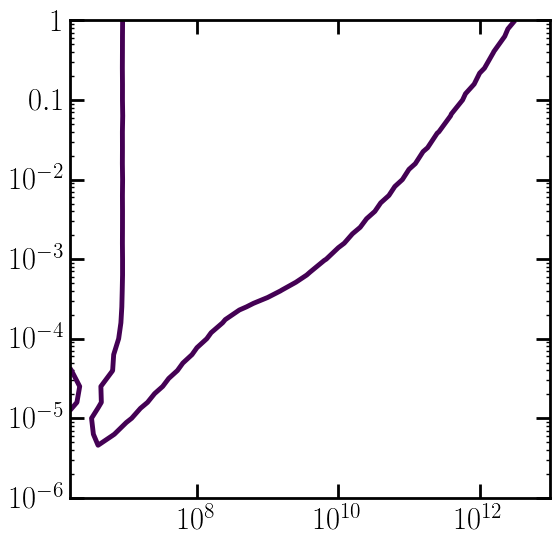

In [14]:
plt.figure()

plt.loglog()

plt.contour(m_m_arr, Q_arr, np.transpose(soln_arr[:,:,-8,0]/phys.kB), levels=[5.1])

In [15]:
pickle.dump((m_m_arr, Q_arr, rs_vec, soln_arr), open('/home/hongwanl/millicharged_DM_with_bath/notebooks/f_1e-4_m_C_1e8.p','wb'))



In [9]:
m_m_err_arr = np.array([m_m_arr[pt[0]] for pt in error_arr])
Q_err_arr   = np.array([Q_arr[pt[1]] for pt in error_arr])
m_m_err_arr.size//Q_arr.size

14

In [11]:
print(m_m_err_arr.size)
print(Q_arr.size)

450
31


In [12]:
450/31

14.516129032258064